In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import StandardScaler

original_data = pd.read_excel('data/owid-covid-data.xlsx')
mobility_data = pd.read_csv('data/Global_Mobility_Report.csv')


In [2]:

unique_countries = list(set(original_data['location']).intersection(set(mobility_data['country_region'])))

country_splitted_data = {}
for country in unique_countries:

    country_data = original_data[original_data['location']==country]
    country_data['date'] = pd.to_datetime(country_data['date'])
    country_data = country_data[['date', 'total_cases_per_million', 'new_cases_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'total_tests_per_thousand', 'new_tests_per_thousand']]


    cmobility_data = mobility_data[mobility_data['country_region']==country]
    cmobility_data['date'] = pd.to_datetime(cmobility_data['date'])
    cmobility_data = cmobility_data[pd.isna(cmobility_data['sub_region_1']) &pd.isna(cmobility_data['sub_region_2']) & pd.isna(cmobility_data['metro_area'])]


    # align pandemics to pandemic start points
    all_country_data = pd.merge(country_data, cmobility_data, on='date')
    for i, day in all_country_data.iterrows():

      if day['total_cases_per_million'] > 0:
        pandemic_start = i
        break

    all_country_data = all_country_data.iloc[pandemic_start:]
    country_splitted_data[country] = all_country_data


countries_of_interest = ['South Korea', 'United States', 'Canada', 'United Kingdom', 'Germany', 'Japan', 'France', 'Italy', 'China', 'India']




In [3]:
def quickplot(country_0, country_1, target_0, use_scaled=False):
    countries_of_interest = list(country_splitted_data.keys())

    fig, ax = plt.subplots()

    data_0 = country_splitted_data[country_0][target_0]
    data_0 = data_0.fillna(method='bfill')
    data_0 = data_0.to_numpy()
    if use_scaled:
        data_0 = StandardScaler().fit_transform(np.expand_dims(data_0,axis=-1))

    print(country_0)
    ax.plot(data_0, label=country_0 + ' ' +target_0 + '(red)', color='red')

    data_1 = country_splitted_data[country_1][target_0]
    data_1 = data_1.fillna(method='bfill')
    data_1 = data_1.to_numpy()
    if use_scaled:
        data_1 = StandardScaler().fit_transform(np.expand_dims(data_1,axis=-1))
    #country = countries_of_interest[2]

    print(country_1)
    ax.plot(data_1, label=country_1 + ' ' +target_0 + '(red)', color='blue')

    every_nth = 2
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

    plt.xlabel('Date')
    ax.set_ylabel(target_0 + ' (red)')

    plt.legend()
    plt.title('New cases')

    plt.show()

In [53]:
target_0 = 'new_cases_per_million'#'total_cases_per_million' works!

##'transit_stations_percent_change_from_baseline' 
all_splitted_data = []
utilized_keys = []
for key in list(country_splitted_data.keys()):
    pd_obj = (country_splitted_data[key][target_0]).fillna(method='bfill')
    pd_obj = pd_obj.rolling(7).mean()
    pd_obj = pd_obj.dropna()
    if len(pd_obj) > 100:
        all_splitted_data.append(StandardScaler().fit_transform(np.expand_dims(pd_obj.to_numpy(), axis=-1)))
        utilized_keys.append(key)

In [54]:
from random import sample
splitted_i = np.asarray(sample(list(range(len(all_splitted_data))), 40))
all_splitted_data = np.asarray(all_splitted_data)[splitted_i]
randomized_keys = [utilized_keys[i] for i in splitted_i]
randomized_keys

[&#39;Bolivia&#39;,
 &#39;Slovenia&#39;,
 &#39;Moldova&#39;,
 &#39;Cameroon&#39;,
 &#39;Netherlands&#39;,
 &#39;Kenya&#39;,
 &#39;Cambodia&#39;,
 &#39;Brazil&#39;,
 &#39;Germany&#39;,
 &#39;United States&#39;,
 &#39;Mali&#39;,
 &#39;Italy&#39;,
 &#39;Israel&#39;,
 &#39;Bangladesh&#39;,
 &#39;United Kingdom&#39;,
 &#39;El Salvador&#39;,
 &#39;Afghanistan&#39;,
 &#39;Kyrgyzstan&#39;,
 &#39;United Arab Emirates&#39;,
 &#39;Turkey&#39;,
 &#39;Tanzania&#39;,
 &#39;Colombia&#39;,
 &#39;Austria&#39;,
 &#39;Ghana&#39;,
 &#39;Taiwan&#39;,
 &#39;Egypt&#39;,
 &#39;Sri Lanka&#39;,
 &#39;Portugal&#39;,
 &#39;New Zealand&#39;,
 &#39;Bosnia and Herzegovina&#39;,
 &#39;Guinea-Bissau&#39;,
 &#39;Gabon&#39;,
 &#39;Slovakia&#39;,
 &#39;Mongolia&#39;,
 &#39;Estonia&#39;,
 &#39;Qatar&#39;,
 &#39;Belize&#39;,
 &#39;Switzerland&#39;,
 &#39;Zimbabwe&#39;,
 &#39;Canada&#39;]

In [56]:
from fastdtw import fastdtw
from itertools import combinations
all_distances = np.zeros((len(all_splitted_data),len(all_splitted_data)))

indice_combinations = list(combinations(range(len(all_splitted_data)), 2))
print('Number of combinations:' + str(len(indice_combinations)))

counter = 0
for I in indice_combinations:
    data_0 = all_splitted_data[I[0]]
    data_1 = all_splitted_data[I[1]]
 #   print([list(country_splitted_data.keys())[x] for x in I])
    distance, path = fastdtw(data_0, data_1)
    all_distances[I[0], I[1]] = distance
    all_distances[I[1], I[0]] = distance
    counter += 1
    if counter % 100 == 0:
       print(counter)

780
100
200
300
400
500
600
700


In [70]:
from sklearn.cluster import DBSCAN, AffinityPropagation

KM = DBSCAN(eps=np.mean(all_distances)/6, metric='precomputed', min_samples=2)
#AffinityPropagation(damping=0.7, affinity='precomputed')

#AgglomerativeClustering(affinity='precomputed', linkage='complete')
#AffinityPropagation(affinity='precomputed')


#DBSCAN(eps=np.mean(all_distances)/7, metric='precomputed')#SpectralClustering(affinity='precomputed')

#SpectralClustering(affinity='precomputed')#

predictions = KM.fit_predict(all_distances)
predictions

array([ 0, -1, -1, -1, -1,  0, -1, -1,  1, -1, -1,  1, -1, -1,  2,  0,  0,
       -1, -1,  1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1,
       -1,  0, -1,  1, -1,  2], dtype=int64)

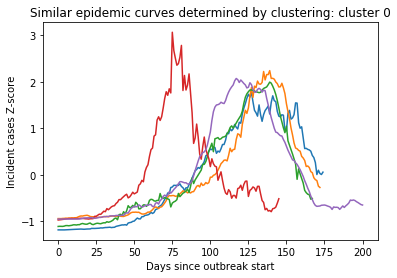

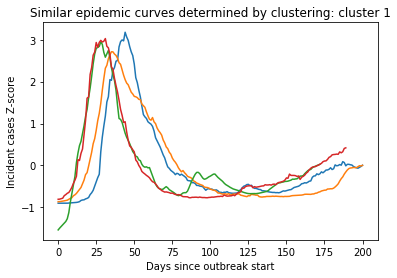

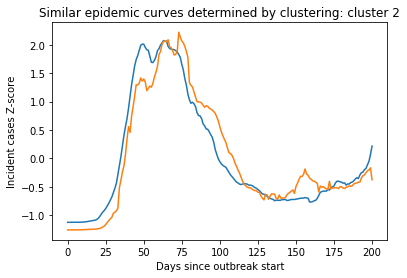

In [71]:

if not os.path.exists('epidemic_cluster'):
    os.mkdir('epidemic_cluster')

for i in range(max(predictions)+1):
    plt.title('Similar epidemic curves determined by clustering: cluster ' + str(i))
    plt.ylabel('Incident cases Z-score')
    plt.xlabel('Days since outbreak start')
    for x in np.asarray(all_splitted_data)[predictions==i][:5]:
        plt.plot(x)
    plt.savefig('epidemic_cluster/cluster '+ str(i) + '.png')
    plt.show()
#plt.plot(all_splitted_data[2])


for i in range(10):
    argsorted = np.argsort(all_distances)
    target = indice_combinations[argsorted[i]]
    target_names = [list(country_splitted_data.keys())[x] for x in target]

    quickplot(target_names[0], target_names[1], target_0, use_scaled=True)
